<a href="https://colab.research.google.com/github/s-horiguchi/escalator/blob/master/floor_field_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from ipywidgets import interact

In [0]:
def get_index_nn(y,x, width, height):
  index_nn = []
  if x > 0:
    index_nn.append([y,x-1])
  if x < width-1:
    index_nn.append([y,x+1])
  if y > 0:
    index_nn.append([y-1,x])
  if y < height-1:
    index_nn.append([y+1,x])
  index_nn = np.array(index_nn)
  return index_nn

class AgentMap(object):
  def __init__(self, width, height):
    self.width = width
    self.height = height
    self.map = np.zeros((height, width, 2), dtype=np.int)
  
  def initialize(self, n_stander=10, n_walker=10):
    self.map[:] = 0
    pos = np.random.choice(np.arange(self.width*self.height), 
                              size=(n_stander+n_walker), replace=False)
    y = pos // self.width
    x = pos % self.width
    atype = np.random.permutation(
        np.hstack([np.zeros(n_stander), np.ones(n_walker)])).astype(np.int)
    self.map[y, x, atype] = 1
    
  def initialize_multinomial(self, p_stander=0.1, p_walker=0.1):
    self.map = np.random.multinomial(
        n=1, pvals=[p_stander, p_walker, 1.0-p_stander-p_walker], 
        size=(self.height, self.width))[:,:,:2]

  def copy(self):
    new_map = AgentMap(self.width, self.height)
    new_map.map = self.map.copy()
    return new_map

  def move(self, prev_pos, next_pos):
    assert self.map[prev_pos[0],prev_pos[1],prev_pos[2]] == 1
    assert self.map[next_pos[0],next_pos[1],next_pos[2]] == 0
    self.map[prev_pos[0],prev_pos[1],prev_pos[2]] = 0
    self.map[next_pos[0],next_pos[1],next_pos[2]] = 1

  def get_vacant(self, indices):
    # return whether each index is vacant or not
    exist_agent = self.map[indices[:,0], indices[:,1]].astype(np.bool)
    vacant = np.bitwise_and(
          np.bitwise_not(exist_agent[:,0]),
          np.bitwise_not(exist_agent[:,1]))
    return vacant
  
  def get_next_cell(self, indices, distance_field, beta=1.0):
    # the most nearest cell to the goal among vacant given cells
    # a_type : "stander" or "walker"
    vacant = self.get_vacant(indices)
    if np.alltrue(np.bitwise_not(vacant)):
      return None
    
    distance = distance_field[indices[:,0], indices[:,1]]
    
    # transition probability ~ 1/(distance+1)^2
    pvals = np.exp(-beta * distance[vacant])
    pvals /= np.sum(pvals)
    #print(pvals)
    picked = np.random.choice(np.arange(len(pvals)), size=1, p=pvals)[0]
    #print(picked)
    return indices[vacant][picked]


In [0]:
class Simulation(object):
  def __init__(self, width=10, height=20, 
               x_exit_stand = 4, x_exit_walk = 6, y_exit_stand = 0, y_exit_walk = 0,
               mu=0.2):
    self.width = width
    self.height = height
    self.mu = mu
    self.history = []

    # create static distance_field
    xcoord = np.repeat(np.arange(width).reshape(1,width), height, axis=0)
    ycoord = np.repeat(np.arange(height).reshape(height, 1), width, axis=1)
    self.distance_field_stand = np.abs(xcoord-x_exit_stand) + np.abs(ycoord-y_exit_stand)
    self.distance_field_walk = np.abs(xcoord-x_exit_walk) + np.abs(ycoord-y_exit_walk)
    
  def initialize(self, **argv):
    agent_map = AgentMap(self.width, self.height)
    agent_map.initialize(**argv)
    self.history.append(agent_map)
    return agent_map
  
  def plot(self, time=-1):
    agent_map = self.history[time]
    
    agent_colors = np.array(["blue", "red"])
    fig = plt.figure(figsize=(8,3))
    fig.add_subplot(1,2,1)
    plt.imshow(self.distance_field_stand, cmap="magma_r")
    plt.colorbar()
    plt.title("distance field for stand")
    plt.scatter(
        np.array(agent_map.map.nonzero())[1,:],
        np.array(agent_map.map.nonzero())[0,:],
        c=agent_colors[np.array(agent_map.map.nonzero())[2,:]]
    )
    fig.add_subplot(1,2,2)
    plt.imshow(self.distance_field_walk, cmap="magma_r")
    plt.colorbar()
    plt.title("distance field for walk")
    plt.scatter(
        np.array(agent_map.map.nonzero())[1,:],
        np.array(agent_map.map.nonzero())[0,:],
        c=agent_colors[np.array(agent_map.map.nonzero())[2,:]]
    )
  
  def step(self):
    agent_map_next = self.history[-1].copy()

    # next_pos -> [(prev_pos1, a_type1), (prev_pos2, a_type2), ...]
    dict_move = defaultdict(lambda : [])


    for y in range(self.height):
      for x in range(self.width):
        #print("--",(y,x), "--")
        if agent_map_next.map[y, x, 0]:
          # a stander exists
          nn_pos = get_index_nn(y, x, self.width, self.height)
          next_pos = agent_map_next.get_next_cell(nn_pos, self.distance_field_stand)
          if next_pos is not None:
            #print(tuple(next_pos), "->", (y,x,0))
            dict_move[tuple(next_pos)].append((y,x,0))
        if agent_map_next.map[y, x, 1]:
          # a walker exists
          nn_pos = get_index_nn(y, x, self.width, self.height)
          next_pos = agent_map_next.get_next_cell(nn_pos, self.distance_field_walk)
          if next_pos is not None:
            #print(tuple(next_pos), "->", (y,x,1))
            dict_move[tuple(next_pos)].append((y,x,1))

    #print(dict(dict_move))
    for next_pos, prev_candidates in dict_move.items():
      if len(prev_candidates) == 0: continue
      elif len(prev_candidates) == 1:
        try:
          agent_map_next.move(
              prev_candidates[0],
              (next_pos[0],next_pos[1],prev_candidates[0][2])
              )
        except:
          print(next_pos)
          print(prev_candidates[0])
          raise
      else:
        # friction
        u = np.random.sample() # uniform(0,1)
        if u < self.mu: # stay
          continue
        else: # move randomly picked agent
          picked = np.random.choice(np.arange(len(prev_candidates)), size=1)[0]
          #print(picked)
          #print(prev_candidates[picked])
          agent_map_next.move(
              prev_candidates[picked],
              (next_pos[0], next_pos[1], prev_candidates[picked][2])
          )
    self.history.append(agent_map_next)
    return agent_map_next
  
  def run(self, n_iter):
    for i in range(n_iter):
      self.step()

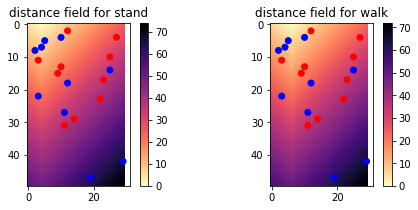

In [13]:
sim = Simulation(width=30, height=50,
                x_exit_stand = 4, x_exit_walk = 6, y_exit_stand = 0, y_exit_walk = 0,
               mu=0.1)
sim.initialize(n_stander=10, n_walker=10)
sim.plot()

In [0]:
sim.run(100)

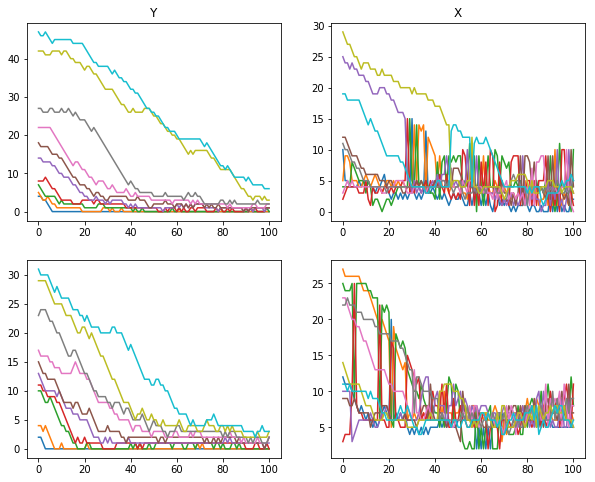

In [15]:
fig = plt.figure(figsize=(10,8))
fig.add_subplot(2,2,1)
plt.plot([np.nonzero(am.map[:,:,0])[0] for am in sim.history])
plt.title("Y")
fig.add_subplot(2,2,2)
plt.plot([np.nonzero(am.map[:,:,0])[1] for am in sim.history])
plt.title("X")

fig.add_subplot(2,2,3)
plt.plot([np.nonzero(am.map[:,:,1])[0] for am in sim.history])
fig.add_subplot(2,2,4)
plt.plot([np.nonzero(am.map[:,:,1])[1] for am in sim.history])

In [16]:
@interact(t=(0,99))
def show(t=0):
  sim.plot(t)

interactive(children=(IntSlider(value=0, description='t', max=99), Output()), _dom_classes=('widget-interact',…